# predict chart type with a random forest classifier
The Plotly Community Feed has more than a million user-generated charts, many of which include data.  I want to use this data to train a model to predict the kinds of design decisions that a human data analyst would make when looking at a table of data:
- What kind of chart to draw?
- What goes on the x axis?
- What goes on the y axis? 
- Are any transforms necisary? 

Conveniently, the precident project vizML has packeged up data from the plotly community feed, along with a package of attributes they calculated from cleaned and de-duplicated data.  As a shortcut, I'll start with their processed attributes. Later, we can go back and collect new data from the plotly community feed to add more information about new types of data -- particularly, about chart types good for visualizing genomic data, like a circos plot.  

### Dependencies

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import os
from os.path import join
import sys
base_path = os.path.abspath(os.path.join('..'))
if base_path not in sys.path:
    sys.path.append(base_path)


### Load Data
This data is created from vizML's features data using the notebook "Load and Clean Plotly Data".
Start there, or download features_with_9_chart_type_labels_888k.csv here (still waiting for it to upload, link coming soon)

In [12]:
data_dir_name = '../data'
data_file_name = 'features_with_chart_type_labels_888k.csv'
df_full = pd.read_csv(os.path.join(data_dir_name, data_file_name))
df_full.info()
# df = df_full # uncomment this one to run everything on the full data set of 888k+ charts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888484 entries, 0 to 888483
Columns: 849 entries, Unnamed: 0 to labels
dtypes: bool(120), float64(726), int64(1), object(2)
memory usage: 4.9+ GB


In [13]:
# take a random subset of data to be able to make and run models on my laptop
# later, skip this step and run df=df_full to run model on full data set

# create a series of weights corresponding to the frequency of each label in the data
label_weights = df_full.groupby('labels')['labels'].transform('count')
# create random sample 
subset_size = 10000
RANDOM_STATE = 42
df = df_full.sample(n=subset_size, replace=False, weights=label_weights, random_state=RANDOM_STATE)

In [14]:
# features data frame without ids or chart type labels
features = df.iloc[:,2:]
features.drop('labels', axis=1, inplace=True)
# one-hot encode labels
labels = pd.get_dummies(df['labels'])
# save a list of column labels for later
chart_names = labels.columns
# labels.head() # take a peek at one-hot encoded labels

In [15]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.15)
print(X_train.shape, X_test.shape) # to make sure they are what we expect

(8500, 846) (1500, 846)


In [ ]:
# SMOTE - Synthetic Minority Oversampling Technique
# to balance dataset
sm = SMOTE(ratio = "minority" , random_state = 42)
X_sm, y_sm = sm.fit_sample(X_train, y_train)

### Tune model hyperparameters
find optimal hyperparameters using a gridsearch

In [22]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [300, 400, 500, 600]
}

# Create a base model to tune
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# this should train a 1*2*4*3 = 24 variations on the model; fitting 3 stratifold folds for each
# 

In [23]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  6.2min finished


{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 400}

In [28]:
best_estimator = grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Define and Train Best Model

In [30]:
model = best_estimator
# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
# predictions 
y_pred = model.predict(X_test)
# Probabilities for each class
probs = model.predict_proba(X_test)
# predicitons as a data frame with chart labels
preds = pd.DataFrame(y_pred)
chart_names = labels.columns.tolist()
preds.columns = chart_names

## Model Performance

In [46]:
# Summarize model performance
def evaluate_model(y_test, preds):
    '''prints a lot of model evaluation metrics, returns accuracy'''
    # ROC-AUC is useful -- but for smaller subsets (e.g., 10k), the model tends predict less common
    # chart types zero times, and in that case AUC can't be computed.
    try:
        print('\nArea Under the Curve: {:.2f}\n'.format(roc_auc_score(y_test, preds)))
    except ValueError:
        pass

    print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, preds)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, preds, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, preds, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, preds, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, preds, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, preds, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, preds, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, preds, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, preds, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, preds, target_names=chart_names))
    
    return accuracy_score(y_test, preds) 

evaluate_model(y_test, preds)

Accuracy: 0.74

Micro Precision: 0.86
Micro Recall: 0.74
Micro F1-score: 0.80

Macro Precision: 0.80
Macro Recall: 0.44
Macro F1-score: 0.55

Weighted Precision: 0.86
Weighted Recall: 0.74
Weighted F1-score: 0.79

Classification Report

              precision    recall  f1-score   support

         bar       0.93      0.39      0.55       103
         box       1.00      0.53      0.69        19
     heatmap       0.00      0.00      0.00         0
   histogram       1.00      0.20      0.33         5
        line       0.89      0.84      0.86       889
         pie       1.00      0.50      0.67         2
     scatter       0.81      0.65      0.72       482

   micro avg       0.86      0.74      0.80      1500
   macro avg       0.80      0.44      0.55      1500
weighted avg       0.86      0.74      0.79      1500
 samples avg       0.74      0.74      0.74      1500



/Users/devon/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/devon/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/devon/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/Users/devon/opt/anaconda3/lib/python3.7/site-package

0.7446666666666667

In [47]:
# confusion matrix
confusion = confusion_matrix(
    y_test.idxmax(1), preds.idxmax(1))
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 83   0   0  11   0   9]
 [  6  10   0   0   0   3]
 [  3   0   1   0   0   1]
 [ 76   0   0 750   0  63]
 [  1   0   0   0   1   0]
 [ 81   0   0  86   0 315]]


Text(0.5, 69.0, 'Predicted label')

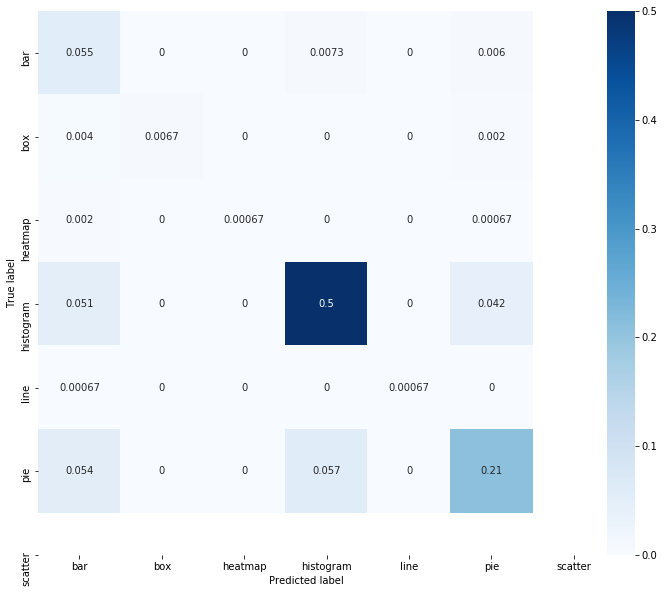

In [48]:
# plot confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            cmap='Blues', xticklabels=chart_names, yticklabels=chart_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Train and evaluate selected model on full data set

In [50]:
# re-load full data set, split into train and test sets
df = df_full # uncomment this one to run everything on the full data set of 888k+ charts
# features data frame without ids or chart type labels
features = df.iloc[:,2:]
features.drop('labels', axis=1, inplace=True)
# one-hot encode labels
labels = pd.get_dummies(df['labels'])
# save a list of column labels for later
chart_names = labels.columns
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.15)
print(X_train.shape, X_test.shape) # to make sure they are what we expect

(755211, 846) (133273, 846)


In [51]:
# define model using best params from above grid search
model = best_estimator
# Fit on training data
model.fit(X_train, y_train)
# predictions 
y_pred = model.predict(X_test)
# probabilities for each class
probs = model.predict_proba(X_test)
# predicitons as a data frame with chart labels
preds = pd.DataFrame(y_pred)
chart_names = labels.columns.tolist()
preds.columns = chart_names

In [52]:
# evaluate
evaluate_model(y_test, preds)


Area Under the Curve: 0.90

Accuracy: 0.85

Micro Precision: 0.94
Micro Recall: 0.85
Micro F1-score: 0.89

Macro Precision: 0.97
Macro Recall: 0.81
Macro F1-score: 0.87

Weighted Precision: 0.94
Weighted Recall: 0.85
Weighted F1-score: 0.89

Classification Report

              precision    recall  f1-score   support

         bar       0.93      0.79      0.86     18623
         box       0.97      0.82      0.89      7308
     heatmap       1.00      0.80      0.89      1879
   histogram       0.93      0.84      0.88      4421
        line       0.96      0.87      0.91     54623
         pie       0.98      0.92      0.95      3879
      sankey       1.00      0.90      0.95       120
     scatter       0.91      0.85      0.88     42370
       table       1.00      0.48      0.65        50

   micro avg       0.94      0.85      0.89    133273
   macro avg       0.97      0.81      0.87    133273
weighted avg       0.94      0.85      0.89    133273
 samples avg       0.85      0

/Users/devon/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8501571961312494

Text(0.5, 69.0, 'Predicted label')

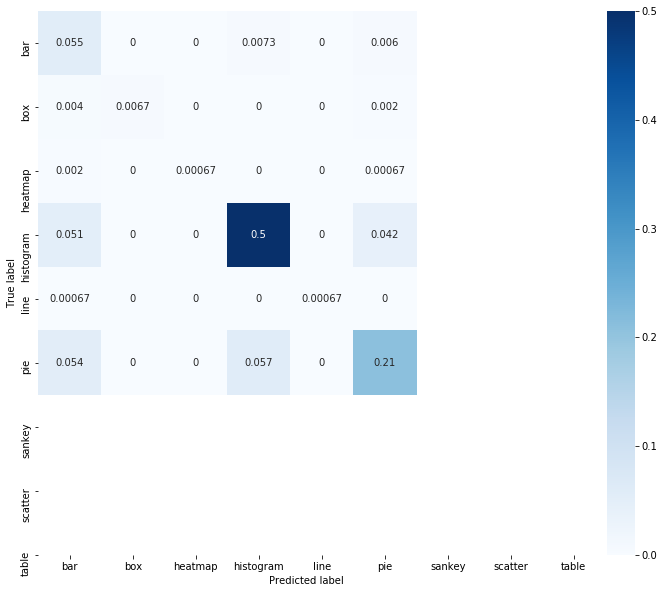

In [53]:
# plot confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            cmap='Blues', xticklabels=chart_names, yticklabels=chart_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [61]:
# confusion matrix
confusion = confusion_matrix(
    y_test.idxmax(1), preds.idxmax(1))

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

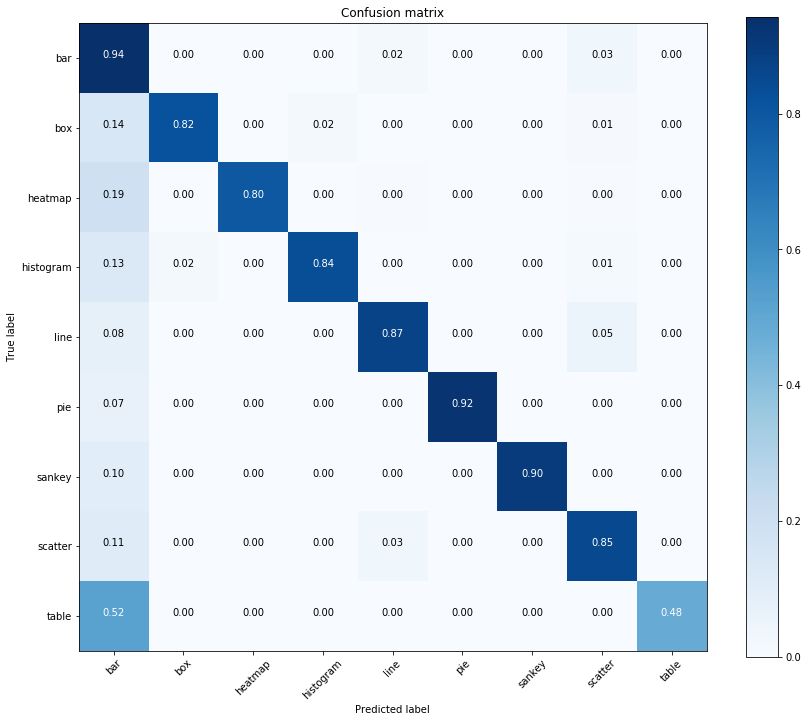

In [71]:
fig, ax = plt.subplots(figsize = (12,10))
plot_confusion_matrix(confusion, chart_names, normalize=True)

In [93]:
def format_feature_importances(model, columns, limit=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importance_table = [
        [columns[i], importances[i]] for i in indices][:limit]
    feature_importance_df = pd.DataFrame(
        feature_importance_table, columns=[
            'feature', 'importance'])
    display(feature_importance_df)

In [94]:
columns = features.columns.tolist()

In [95]:
format_feature_importances(model, columns)

,feature,importance
0,length-agg-min,0.009960
1,length-agg-max,0.008754
2,length-agg-mean,0.008253
3,data_type_is_time-agg-num,0.007430
4,entropy-agg-min,0.006781
5,y_in_name-agg-num,0.006136
6,entropy-agg-max,0.006074
7,general_type_is_t-agg-has,0.005607
8,general_type_entropy,0.005602
9,field_name_length-agg-mean,0.005571
